In [11]:
from matplotlib import pyplot as plt
import pandas as pd
from collections import defaultdict
import numpy as np
import os
import itertools

# Read Confusion

In [18]:
dataname = "StackOverflowBiology_0"
ep=100
labelnum = 3

In [19]:
def read_confusion_matrices(dirpath, fname="log_test_confusion.txt", ep=10, labelnum=3):
    if os.path.isfile(dirpath + "log_valid_confusion.txt") is True:
        fname = "log_valid_confusion.txt"
        evalname = "valid"
    else:
        evalname = "test"
        
    if os.path.isfile(dirpath + fname) is False:
        # print("not exist", dirpath + fname)
        return -1
    if os.path.isfile(dirpath + "log_{}_micro.txt".format(evalname)):
        num_epoch = 0
        num_times = 0
        best_f1 = 0
        total_epoch = 0
        with open(dirpath + "log_{}_micro.txt".format(evalname), "r") as f:
            for i, line in enumerate(f.readlines()):
                ep_str = line.rstrip().split(":")[0]
                f1_str = line.rstrip().split(":")[-1]
                epoch = int(ep_str.split(" ")[0])
                f1 = float(f1_str)
                if best_f1 < f1:
                    num_epoch = epoch
                    num_times = i + 1
                    best_f1 = f1
                else:
                    total_epoch = epoch
    else:
        best_f1 = 0
        num_epoch = ep
        total_epoch = ep
        num_times = 1
            
    with open(dirpath + fname, "r") as f:
        one_input = []
        for line in f.readlines():
            if len(one_input) == labelnum:
                num_times -= 1
                if num_times == 0:
                    break
                one_input = []
            one_input.append(line)
                
    confusion_matrix = np.zeros((labelnum,labelnum))
    for i in range(labelnum):
        line = one_input[i].rstrip()
        tmp = line.split("\t")
        for c, v in enumerate(tmp):
            confusion_matrix[i,c] = int(v)

    accuracy = sum([confusion_matrix[i, i] for i in range(labelnum)]) / (np.sum(confusion_matrix))
    
    rec_bar = []
    label_num = []
    recall_micro_denom = 0
    recall_micro_numer = 0
    for i in range(confusion_matrix.shape[0]):
        row_sum = np.sum(confusion_matrix[i])
        label_num.append(row_sum)
        ans = confusion_matrix[i,i]
        if row_sum == 0:
            rec_bar.append(0)
        else:
            rec_bar.append(ans / row_sum)
        recall_micro_denom += row_sum
        recall_micro_numer += ans
    
    recall_macro = sum(rec_bar) / labelnum
    recall_micro = recall_micro_numer / recall_micro_denom
    
    prec_bar = []
    pred_label_num = []
    precision_micro_denom = 0
    precision_micro_numer = 0
    for i in range(confusion_matrix.shape[0]):
        col_sum = np.sum(confusion_matrix[:,i])
        pred_label_num.append(col_sum)
        ans = confusion_matrix[i,i]
        if col_sum == 0:
            prec_bar.append(0)
        else:
            prec_bar.append(ans / col_sum)
        precision_micro_denom += col_sum
        precision_micro_numer += ans
    precision_macro = sum(prec_bar) / labelnum
    precision_micro = precision_micro_numer / precision_micro_denom
    
    f1_bar = []
    for i in range(len(rec_bar)):
        if (prec_bar[i] + rec_bar[i]) == 0:
            f1_bar.append(0)
        else:
            f1_bar.append(2 * ( (prec_bar[i] * rec_bar[i]) / (prec_bar[i] + rec_bar[i]) ))
    f1score_macro = sum(f1_bar) / labelnum
    f1score_micro = 2 * ( (precision_micro * recall_micro) / (precision_micro + recall_micro))
    
    if f1score_macro == 1.00:
        print(confusion_matrix)
        print(rec_bar)
        print(prec_bar)
        print(f1_bar)
        print(dirpath)
    assert best_f1 == 0 or best_f1 == f1score_micro, dirpath + "\t" + str(best_f1) + " " + str(f1score_micro)
    
    # Label Diff
    numlabelrate = []
    total_label_ratio = 0
    all_labels = sum(label_num)
    for i in range(labelnum):
        numlabelrate.append((abs(pred_label_num[i] - label_num[i]) / label_num[i])) # pred_label_num[i] / label_num[i]) # distance??
        total_label_ratio += (abs(pred_label_num[i] - label_num[i]) / label_num[i]) * (label_num[i] / all_labels)
#         numlabelrate.append(1.0 - (abs(pred_label_num[i] - label_num[i]) / label_num[i])) # pred_label_num[i] / label_num[i]) # distance??
#         total_label_ratio += (abs(pred_label_num[i] - label_num[i]) / label_num[i])
    
    
    result = {
        "accuracy" : accuracy,
        "f1_micro": f1score_micro,
        "f1_macro": f1score_macro,
        "num_epoch" : num_epoch,
        "total_epoch" : total_epoch,
        "labeldiff" : total_label_ratio,
    }
    for i in range(labelnum):
        result["recall_" + str(i)] = rec_bar[i]
        result["precision_" + str(i)] = prec_bar[i]
        result["f1_" + str(i)] = f1_bar[i]
        result["labelratio_" + str(i)] = numlabelrate[i]
    return result

# Make Dict

In [20]:
resultdict = defaultdict(dict)

In [21]:
model2bestparam = {}

In [22]:
# Add F1 macro
for initvec in ["rw"]: # "onehot", "adj",
    orgdir = "../results/" + dataname + "/" + initvec + "/"
    
    refined_list = defaultdict(list)
    for modelname in os.listdir(orgdir):
        modelnamedir = orgdir + modelname + "/"
#         print(modelnamedir)
        if "past" in modelname:
            continue
        if os.path.isdir(modelnamedir) is False:
            continue
        embedder = modelname.split("_")[0]
        refined_list[embedder].append(modelnamedir)
    
    model2param = defaultdict(dict)
    for modelname in refined_list:
        for modelnamedir in refined_list[modelname]: # number of layer
#             print(modelnamedir)
            for paramname in os.listdir(modelnamedir): # parameters   
                # assert Search Space
                lr_ss = ["0.001", "0.0001"]
                do_ss = ["0.7"]
                bs_ss = ["128", "64", "-1"] # 512, 256
                hd_ss = ["64"]
                od_ss = ["128"]
                ni_ss = ["4"]
                sp_ss = ["-1"]
                
                split_output = paramname.split("_")
                if dataname in ["emailEnron_0", "emailEu_0", "StackOverflowPhysics_0", "StackOverflowBiology_0", "AMinerAuthor_0"]:
                    if "transformer" in modelname:
                        if "partial" in modelname and dataname == "StackOverflowBiology_0":
                            sp_ss = ["40", "-1"]
                        else:
                            sp_ss = ["40"]
                    elif "hcha" in modelname:
                        sp_ss = ["-1"]
                    elif dataname != "StackOverflowBiology_0":
                        sp_ss = ["40", "100"]
                if dataname == "AMinerAuthor_0":
                    bs_ss = ["512", "256"]
                
                if len(split_output) == 12:
                    if modelname == "hcha":
                        _, hd, _, od, _, do, _, lr, _, ni, _, sp = split_output
                        bs = "-1"
                        vr = "-"
                        lr_ss = ["0.01", "0.005", "0.05", "0.1", "0.03"]
                        do_ss = ["0.3", "0.5", "0.7"]
                    else:
                        _, hd, _, od, _, bs, _, lr, _, ni, _, sp = split_output
                        do = "0.7"
                        vr = "-"
                elif len(split_output) == 14:
                    _, hd, _, od, _, bs, _, lr, _, ni, _, sp, _, vr = split_output
                    do = "0.7"
                else:
                    continue
                
                if lr not in lr_ss:
                    continue
                elif do not in do_ss:
                    continue
                elif bs not in bs_ss:
                    continue
                elif hd not in hd_ss:
                    continue
                elif od not in od_ss:
                    continue
                elif ni not in ni_ss:
                    continue
                elif sp not in sp_ss:
                    continue
                    
                # get Result
                paramnamedir = modelnamedir + paramname + "/"
                if os.path.isdir(paramnamedir) is False:
                    continue
                res = read_confusion_matrices(paramnamedir, labelnum=labelnum)
                if res != -1:
                    modelname_w_param = modelname + "/" + str(vr)
                    if modelname_w_param not in model2param:
                        model2param[modelname_w_param] = {}
                        
                    f1 = (res["f1_micro"] + res["f1_macro"]) / 2
#                     if modelname == "transformer-pure-pure":
#                         print(paramnamedir)
#                         print(res["f1_micro"], "\t", res["f1_macro"])
#                         print(" * * *")
                    
                    if paramnamedir not in model2param[modelname_w_param]:
                        model2param[modelname_w_param][paramnamedir] = f1
                    elif model2param[modelname_w_param][paramnamedir] < f1:
                        model2param[modelname_w_param][paramnamedir] = f1
    
    for modelname_w_param in model2param.keys():
        param2f1 = model2param[modelname_w_param]
        if len(param2f1) == 0:
            print(modelname_w_param)
            continue
        sorted_param = sorted(list(param2f1.keys()), key=lambda x: param2f1[x], reverse=True)
        for paramkey in sorted_param:
            res = read_confusion_matrices(paramkey, ep=ep, labelnum=labelnum)
            if res != -1:
                res["searchspace"] = len(param2f1)
                paramname = paramkey.split("/")[-2]
                split_output = paramname.split("_")
                if len(split_output) == 12:
                    _, hd, _, od, _, bs, _, lr, _, ni, _, sp = split_output
                elif len(split_output) == 14:
                    _, hd, _, od, _, bs, _, lr, _, ni, _, sp, _, vr = split_output
                else:
                    assert(False)
                res["sampling"] = int(sp)
#                 if "hcha" not in modelname_w_param and len(param2f1) > 8:
#                     print(param2f1.keys())
                if modelname_w_param not in resultdict:
                    resultdict[modelname_w_param] = res
                    model2bestparam[modelname_w_param] = paramkey

In [23]:
# with open("../results/BestParam_{}.txt".format(dataname), "w") as f:
for k,v in model2bestparam.items():
#         f.write(k + "\t" + v + "\n")
    print(k, v)

transformerHNHN-RankQ-PrevQ/- ../results/StackOverflowBiology_0/rw/transformerHNHN-RankQ-PrevQ_nl2_sm_snl1/hd_64_od_128_bs_64_lr_0.0001_ni_4_sp_40/
transformer-LAPPE-PrevQ/- ../results/StackOverflowBiology_0/rw/transformer-LAPPE-PrevQ_nl1_sm_snl1/hd_64_od_128_bs_128_lr_0.001_ni_4_sp_40/
transformer-RankPE-PrevQ/- ../results/StackOverflowBiology_0/rw/transformer-RankPE-PrevQ_nl2_sm_snl1/hd_64_od_128_bs_64_lr_0.001_ni_4_sp_40/
transformer-VRankQ-PrevQ/- ../results/StackOverflowBiology_0/rw/transformer-VRankQ-PrevQ_nl1_sm_snl1/hd_64_od_128_bs_64_lr_0.001_ni_4_sp_40/
transformer-RWPE-PrevQ/- ../results/StackOverflowBiology_0/rw/transformer-RWPE-PrevQ_nl1_sm_snl1/hd_64_od_128_bs_64_lr_0.001_ni_4_sp_40/
transformer-WLPE-PrevQ/- ../results/StackOverflowBiology_0/rw/transformer-WLPE-PrevQ_nl1_sm_snl1/hd_64_od_128_bs_128_lr_0.001_ni_4_sp_40/
transformerHAT-RankQ-PrevQ/- ../results/StackOverflowBiology_0/rw/transformerHAT-RankQ-PrevQ_nl2_sm_snl1/hd_64_od_128_bs_128_lr_0.001_ni_4_sp_40/


In [24]:
# Output Run Code
if dataname == "DBLP2_0":
    dn = dataname.split("_")[0]
    data_line = "--dataset_name {} --exist_hedgename --k 0".format(dn)
elif dataname == "emailEu_0":
    dn = dataname.split("_")[0]
    data_line = "--dataset_name {} --output_dim 2 --k 0".format(dn)
else:
    dn = dataname.split("_")[0]
    data_line = "--dataset_name {} --k 0".format(dn)
    
with open("../results/BestParam_{}.txt".format(dataname), "w") as f:
    for k in sorted(model2bestparam.keys()):
        v = model2bestparam[k]
        model_param, train_param = v.split("/")[-3:-1]
        modelname, nl, _, _ = model_param.split("_")
        nl = nl[-1]

        tmp = modelname.split("-")
        embedder = tmp[0]
        vr = ""
        if embedder == "hcha":
            run_line = "CUDA_VISIBLE_DEVICES=${cuda} python train_wdgl_w_full_batch.py"
        else:
            run_line = "CUDA_VISIBLE_DEVICES=${cuda} python train_wdgl_w.py"
        
        if len(tmp) == 1:
            encode_type = ""
            decode_type = ""
            model_line = "--embedder {}".format(embedder)
        elif len(tmp) == 2:
            encode_type = ""
            decode_type = tmp[1]
            model_line = "--embedder {} --decode_type {}".format(embedder, decode_type)
        elif len(tmp) == 3:
            encode_type, decode_type = tmp[1], tmp[2]
            model_line = "--embedder {} --encode_type {} --decode_type {}".format(embedder, encode_type, decode_type)
        elif len(tmp) == 4:
            encode_type, decode_type, partial = tmp[1], tmp[2], tmp[3]
            model_line = "--embedder {} --encode_type {} --decode_type {} --partial".format(embedder, encode_type, decode_type)
        else:
            assert(False)
        model_line += " --num_layers {} --scorer sm --scorer_num_layers 1".format(nl)
        if encode_type.strip() == "RankQ":
            vr = "degree_nodecentrality,eigenvec_nodecentrality,pagerank_nodecentrality,kcore_nodecentrality"
            
        
        if len(train_param.split("_")) == 12:
            _, hd, _, od, _, bs, _, lr, _, ni, _, sp = train_param.split("_")
        elif len(train_param.split("_")) == 14:
            _, hd, _, od, _, bs, _, lr, _, ni, _, sp, _, vr = train_param.split("_")
            vr += "_nodecentrality"
        if embedder == "hcha":
            bs = -1
        
        param_line = "--optimizer adam --bs {} --dropout 0.7 --gamma 0.99 --dim_hidden 64 --lr {} --dim_edge {} --dim_vertex {} --epochs 100 --test_epoch 5 --sampling {}".format(bs, lr, od, od, sp)
        testline = "--evaltype test --fix_seed --seed ${seed} --use_gpu"
#         print(v)
#         print(model_line, param_line)
        if len(vr) == 0:        
            f.write(run_line + " " + data_line + " " + model_line + " " + param_line + " " + testline + "\n")
        else:
            f.write(run_line + " " + data_line + " " + model_line + " --vrank_input " + vr + " " + param_line + " " + testline + "\n")
            

In [25]:
# if dataname != "emailEu_0":
evallist = ["f1_micro", "f1_macro", "labeldiff"] + list(itertools.chain.from_iterable([["recall_" + str(i),  "precision_" + str(i), "f1_" + str(i), 'labelratio_' + str(i)] for i in range(labelnum)]))
# else:
#     evallist = ["f1_micro", "f1_macro"] 

In [27]:
outputname = "train_result_{}.txt".format(dataname)
with open(outputname, "w") as f:
    line = "Model,InitVec,Encode,Decode,Sampling,Ranking,Partial," + ",".join(evallist) + ",searchspace,epoch"
    f.write(line + "\n")

In [29]:
for k in resultdict:
    tmp = k.split("/")
    _k = tmp[0]
    # initvec = tmp[1]
    sp = resultdict[k]["sampling"]
    vr = tmp[1]
    partialflag = "-"

    modelname = _k
    tmp = modelname.split("-")
    if "partial" in modelname:
        partialflag = "partial"
        tmp = tmp[:-1]
    if len(tmp) == 1:
        model = tmp[0]
        encode = "-"
        decode = "-"
    elif len(tmp) == 2:
        model = tmp[0]
        if "transformer" in modelname:
            encode = "-"
            decode = tmp[1]
        else:
            encode = tmp[1]
            decode = "-"
    elif len(tmp) == 3:
        model, encode, decode = tmp
    try:
        line = [model, initvec, encode, decode, str(sp), str(vr), partialflag] + [str(resultdict[k][e]) for e in evallist] + [str(resultdict[k]["searchspace"]), str(resultdict[k]["num_epoch"])]
    except:
        print(k)
        print(resultdict[k])
        break
    line = ",".join(line)
    with open(outputname, "a") as f:
        f.write(line + "\n")

### Write Evaluation

In [30]:
# usecolumns = ['Model', 'Encode', 'Decode', 'Sampling', "Ranking", "Partial", 'f1_micro', 'f1_macro', 'f1_0', 'labelratio_0', 'f1_1', 'labelratio_1', 'f1_2', 'labelratio_2', 'epoch', "searchspace"]
usecolumns = ['Model', 'Encode', 'Decode', 'Sampling', "Ranking", "Partial", 'f1_micro', 'f1_macro', "epoch", "searchspace", "labeldiff"]

In [31]:
print(dataname)
d = pd.read_csv(outputname, usecols=usecolumns)
# d = d[d["Decode"] != "AvgAgg"]
d = d.sort_values(by=["f1_micro"], ascending=False)
d

StackOverflowBiology_0


,Model,Encode,Decode,Sampling,Ranking,Partial,f1_micro,f1_macro,labeldiff,searchspace,epoch
2,transformer,RankPE,PrevQ,40,-,-,0.733404,0.681482,0.066472,8,30
3,transformer,VRankQ,PrevQ,40,-,-,0.718337,0.652812,0.115749,6,15
1,transformer,LAPPE,PrevQ,40,-,-,0.718249,0.649657,0.144820,6,25
4,transformer,RWPE,PrevQ,40,-,-,0.715856,0.657182,0.129930,6,20
6,transformerHAT,RankQ,PrevQ,40,-,-,0.704245,0.649426,0.106532,8,25
0,transformerHNHN,RankQ,PrevQ,40,-,-,0.699814,0.645060,0.117522,8,30
5,transformer,WLPE,PrevQ,40,-,-,0.680493,0.635184,0.166622,8,75


In [59]:
print(dataname)
# usecolumns = ['Model', 'Encode', 'Decode', 'Sampling', "Ranking", "Partial", 'f1_micro', 'f1_macro', 'f1_0', 'labelratio_0', 'f1_1', 'labelratio_1', 'f1_2', 'labelratio_2', 'epoch', "searchspace"]
usecolumns = ['Model', 'Encode', 'Decode', 'Sampling', "Ranking", "Partial", 'f1_micro', 'f1_macro', "f1_0", "f1_1", "f1_2"]
d = pd.read_csv(outputname, usecols=usecolumns)
# d = d[d["Decode"] != "AvgAgg"]
d = d.sort_values(by=["f1_macro"], ascending=False)
d

emailEnron_0


,Model,Encode,Decode,Sampling,Ranking,Partial,f1_micro,f1_macro,f1_0,f1_1,f1_2
2,RandomForest,-,-,-1,-,-,0.842739,0.774051,0.880584,0.840994,0.600574
3,transformer,RankQ,PrevQ,40,-,-,0.820052,0.761356,0.862576,0.809422,0.612070
12,transformer,-,PrevQ,40,-,-,0.815639,0.759582,0.856201,0.808327,0.614218
4,hat,-,-,100,-,-,0.815325,0.754338,0.858156,0.805185,0.599674
5,transformer,pure,PrevQ,40,-,-,0.822292,0.753927,0.865212,0.814897,0.581672
9,hnhn,-,-,100,-,-,0.817534,0.746463,0.860944,0.809731,0.568714
7,transformer,pure,pure,40,-,-,0.808179,0.743322,0.859444,0.790061,0.580462
11,transformer,-,pure2,40,-,-,0.804284,0.733816,0.855503,0.787084,0.558862
8,hgnn,-,-,40,-,-,0.788469,0.727741,0.835216,0.775792,0.572215
6,unigcnii,-,-,100,-,-,0.771787,0.721173,0.819504,0.761581,0.582434


In [44]:
for k in resultdict.keys():
    print(k)

baseline1
baseline0
RandomForest
transformer-RankQ-pure/-
transformer-RankQ-PrevQ-partial/-
transformer-RankQ-AvgAgg/-
transformer-RankQ-PrevQ/pagerank
transformer-RankQ-PrevQ/eigenvec
transformer-RankQ-PrevQ/kcore
transformer-RankQ-PrevQ/degree
transformer-RankQ-PrevQ/-
hat/-
transformer-pure-PrevQ/-
unigcnii/-
transformer-pure-pure/-
hgnn/-
hnhn/-
transformer-pure/-
transformer-pure2/-
transformer-PrevQ/-
hcha/-


In [17]:
# baseline1
# baseline0
# RandomForest
# transformer-RankQ-pure/-1/-
# transformer-RankQ-PrevQ-partial/-1/-
# transformer-RankQ-AvgAgg/-1/-
# transformer-RankQ-PrevQ/-1/pagerank
# transformer-RankQ-PrevQ/-1/eigenvec
# transformer-RankQ-PrevQ/-1/kcore
# transformer-RankQ-PrevQ/-1/degree
# transformer-RankQ-PrevQ/-1/-
# hat/-1/-
# transformer-pure-PrevQ/-1/-
# unigcnii/-1/-
# transformer-pure-pure/-1/-
# hgnn/-1/-
# hnhn/-1/-
# transformer-pure/-1/-
# transformer-pure2/-1/-
# hcha/-1/-

baselines = {
#     "Baseline_Uniform" : "baseline0",
#     "Baseline_Fix" : "baseline1",
#     "RandomForest" : "RandomForest",
    "HAT" : "hat/-1/-",
    "HCHA" : "hcha/-1/-",
    "UniGCNII" : "unigcnii/-1/-",
    "HGNN" : "hgnn/-1/-",
    "HNHN" : "hnhn/-1/-",
    "AllSet" : "transformer-pure2/-1/-",
    "SetTransformer" : "transformer-pure-pure/-1/-",
    "OurModel" : "transformer-RankQ-PrevQ/-1/-"
}
abl_rank = {
    "NoRank": "transformer-pure-PrevQ/-1/-",
    "OurModel:Rank" : "transformer-RankQ-PrevQ/-1/-"
}
abl_att = {
    "AllSet:NoWithinAtt": "transformer-pure-PrevQ/-1/-",
    "SetTransformer:WithinAtt" : "transformer-pure-pure/-1/-",
    "OurModel:WithinAtt" : "transformer-pure-PrevQ/-1/-",
    "OurModel:WithinAtt+Rank" : "transformer-RankQ-PrevQ/-1/-",
}

abl_agg = {
    "Agg_pure" : "transformer-RankQ-pure/-1/-",
    "Agg_Avg" : "transformer-RankQ-AvgAgg/-1/-",
    "OurModel:PrevQ" : "transformer-RankQ-PrevQ/-1/-",
}
abl_part = {
    "Partial" : "transformer-RankQ-PrevQ-partial/-1/-",
    "OurModel:Bi-Dir" : "transformer-RankQ-PrevQ/-1/-"
}
abl_rank_esp = {
    "EigenVector" : "transformer-RankQ-PrevQ/-1/eigenvec",
    "PageRank" : "transformer-RankQ-PrevQ/-1/pagerank",
    "Degree" : "transformer-RankQ-PrevQ/-1/degree",
    "Kcore" : "transformer-RankQ-PrevQ/-1/kcore",
    "OurModel:All" : "transformer-RankQ-PrevQ/-1/-",
}

In [18]:
def plot_all(label2name, result, w=1/10):
    plt.figure(dpi=100, figsize=(6,4))
    
    if dataname == "emailEu_0":
        evallist = ['f1_micro', 'f1_macro', 'f1_0', 'f1_1']
    else:
        evallist = ['f1_micro', 'f1_macro', 'f1_0', 'f1_1', 'f1_2'] #, 'labelratio_' + str(l)] # ['labelratio_' + str(l) for l in range(3)] # 
    
    refinednames = [label for label in label2name.keys() if label2name[label] in result]
    for lidx, label in enumerate(refinednames):
        ys = [result[label2name[label]][e] for e in evallist]
        if "OurModel" in label:
            # plt.plot(np.arange(len(evallist)), ys, label=label, marker="o", linewidth=8, alpha=0.9, markersize=8, color="#FF5675")
            plt.bar(np.arange(len(evallist)) + (w * (lidx-1)), ys, width=w, align='center', label=label, color="#FF5675")
        else:
            # plt.plot(np.arange(len(evallist)), ys, label=label, marker="o", linewidth=5, alpha=0.7, markersize=8)
            plt.bar(np.arange(len(evallist)) + (w * (lidx-1)), ys, width=w, align='center', label=label)
    # ys = [result["RandomForest"][e] for e in evallist]
    # minx, maxx = plt.xlim()
    # plt.hlines(1, minx, maxx, linestyle="dashed", color="black", linewidth=4)

    ax = plt.gca()
    ax.set_xticks(np.arange(len(evallist)))
    ax.set_xticklabels(evallist, fontsize=13)

    plt.legend(bbox_to_anchor=(1,1), fontsize=15)
    plt.title(dataname)
    # ax.xaxis_date()

No handles with labels found to put in legend.


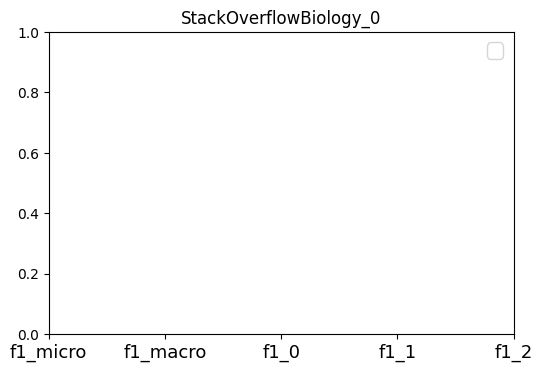

In [187]:
plot_all(abl_rank, resultdict, w=1/3)

In [188]:
def plot_label_detail(label2name, result, w=1/6):
    fig, axes = plt.subplots(dpi=100, figsize=(20,4), nrows=1, ncols=3)

    for l in range(3):
        ax = axes[l]
        evallist = ['recall_' + str(l), 'precision_' + str(l), 'f1_' + str(l), 'labelratio_' + str(l)]
        for lidx, label in enumerate(label2name.keys()):
            if label2name[label] not in result:
                continue
            ys = [result[label2name[label]][e] for e in evallist]
            
            if "OurModel" in label:
                ax.plot(np.arange(len(evallist)), ys, label=label, marker="o", linewidth=10, alpha=0.8, markersize=8, color="#FF5675")
            else:
                ax.plot(np.arange(len(evallist)), ys, label=label, marker="o", linewidth=6, alpha=0.7, markersize=8)

#             if label not in colordict:
#                 ax.bar(np.arange(len(evallist)) + (w * (lidx-1)), ys, width=w, align='center', label=label)
#             else:
#                 ax.bar(np.arange(len(evallist)) + (w * (lidx-1)), ys, width=w, align='center', label=label, color=colordict[label])
        
        # ys = [result["RandomForest"][e] for e in evallist]
        # ax.plot(evallist, ys, linestyle="dashed", color="black", label="RandomForest", linewidth=7)
        minx, maxx, _, _ = ax.axis()
        ax.hlines(1, minx, maxx, linestyle="dashed", color="black", linewidth=4)
    
        ax.set_xticks(np.arange(len(evallist)))
        ax.set_xticklabels(evallist, fontsize=13)

        if l == 2:
            ax.legend(bbox_to_anchor=(1,1), fontsize=15)
        # ax.xaxis_date()
        ax.set_title("Label : " + str(l), fontsize=15)
        ax.autoscale(tight=True)

No handles with labels found to put in legend.


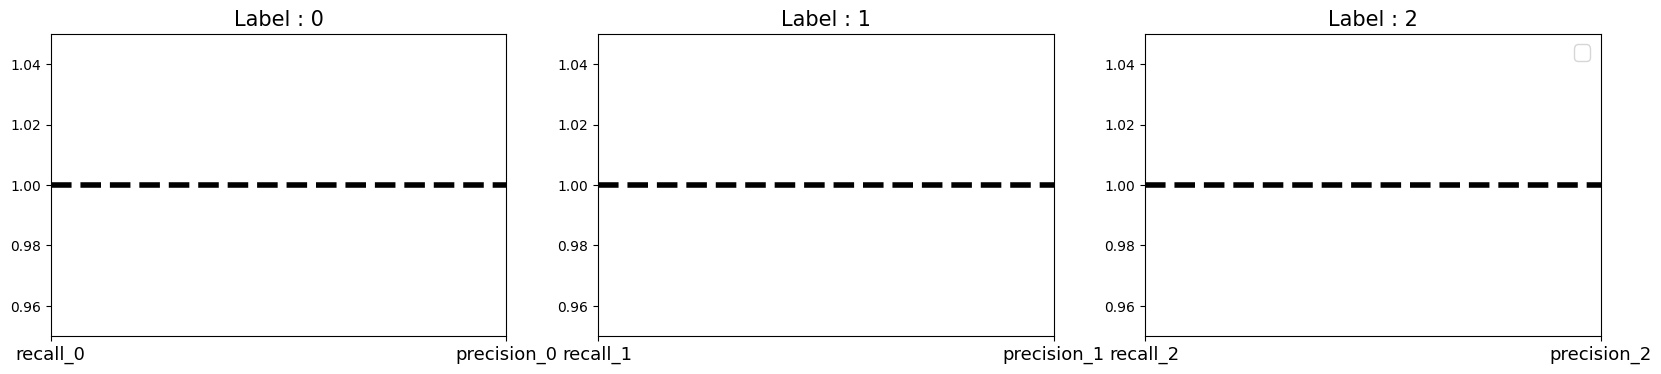

In [189]:
plot_label_detail(abl_part, resultdict)

In [190]:
# no_rank[dataname] = resultdict["transformer-pure-PrevQ/-1/-"]
# rank[dataname] = resultdict["transformer-RankQ-PrevQ/-1/-"]
# no_att[dataname] = resultdict["transformer-pure2/-1/-"]
# att1[dataname] = resultdict["transformer-pure-pure/-1/-"]
# att2[dataname] = resultdict["transformer-pure-PrevQ/-1/-"]
# att3[dataname] = resultdict[ "transformer-RankQ-PrevQ/-1/-"]

In [206]:
no_rank[dataname] = resultdict["transformer-pure-PrevQ/40/-"]
rank[dataname] = resultdict["transformer-RankQ-PrevQ/40/-"]

In [207]:
no_att[dataname] = resultdict["transformer-pure2/40/-"]
att1[dataname] = resultdict["transformer-pure-pure/40/-"]
att2[dataname] = resultdict["transformer-pure-PrevQ/40/-"]
att3[dataname] = resultdict[ "transformer-RankQ-PrevQ/40/-"]

f1_micro
['DBLP2_0', 'AMinerAuthor_0', 'emailEnron_0', 'emailEu_0', 'StackOverflowBiology_0', 'StackOverflowPhysics_0']
f1_macro
['DBLP2_0', 'AMinerAuthor_0', 'emailEnron_0', 'emailEu_0', 'StackOverflowBiology_0', 'StackOverflowPhysics_0']
labeldiff
['DBLP2_0', 'AMinerAuthor_0', 'emailEnron_0', 'emailEu_0', 'StackOverflowBiology_0', 'StackOverflowPhysics_0']


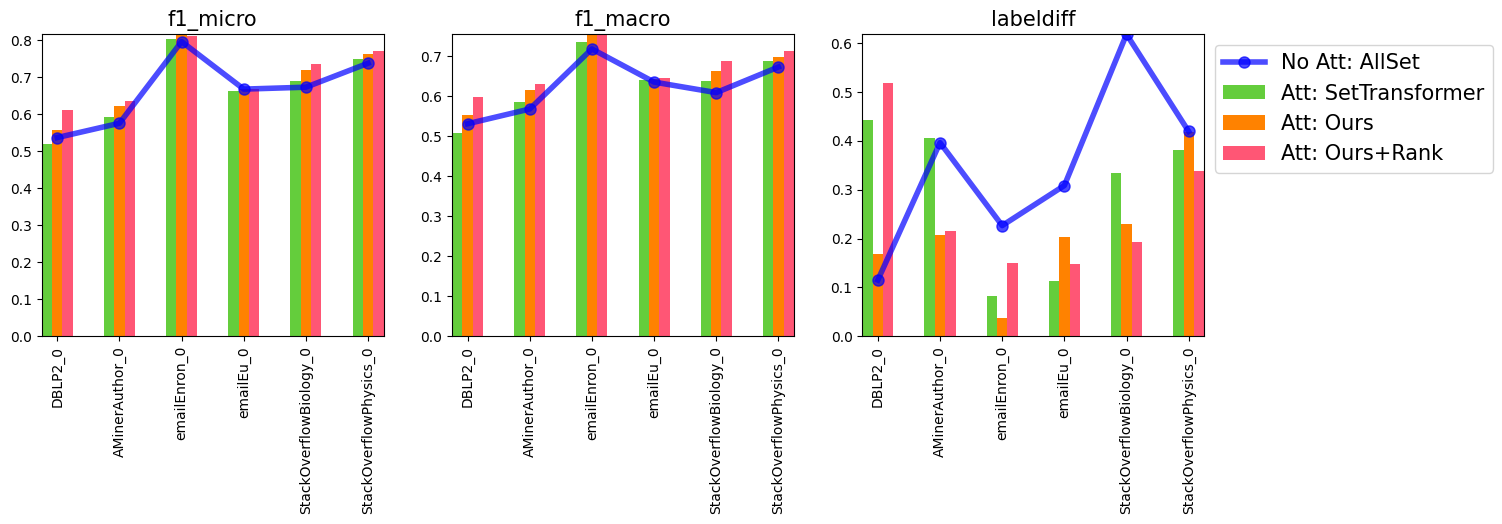

In [208]:
# evallist = ["f1_0", "f1_1", "f1_2"]
evallist = ["f1_micro", "f1_macro", "labeldiff"]
# evallist = ["labelratio_0", "labelratio_1", "labelratio_2"]
w = 1/6
fig, axes = plt.subplots(dpi=100, figsize=(15,4), nrows=1, ncols=len(evallist))

for i in range(len(evallist)):
    ax = axes[i]
    evalname =  evallist[i]
    # xs
    xs = list(no_rank.keys())
    if "2" in evalname:
        xs.remove('emailEu_0')
    print(evalname)
    print(xs)
    
    # ys
    ys =[no_att[x][evalname] for x in xs]
    ax.plot(xs, ys, label="No Att: AllSet", marker="o", linewidth=4, alpha=0.7, markersize=8, color="blue")
#     ax.bar(np.arange(len(xs)) + (w * (-2)), ys, width=w, align='center', label="No Att: AllSet")
    ys =[att1[x][evalname] for x in xs]
#     ax.plot(xs, ys, label="Att: SetTransformer", marker="o", linewidth=6, alpha=0.7, markersize=8)
    ax.bar(np.arange(len(xs)) + (w * (-1)), ys, width=w, align='center', label="Att: SetTransformer", color="#64CD3C")
    ys =[att2[x][evalname] for x in xs]
#     ax.plot(xs, ys, label="Att: Ours", marker="o", linewidth=6, alpha=0.7, markersize=8)
    ax.bar(np.arange(len(xs)) + (w * (0)), ys, width=w, align='center', label="Att: Ours", color="#FF8200")
    ys = [att3[x][evalname] for x in xs]
#     ax.plot(xs, ys, label="Att: Ours+Ranking", marker="o",  linewidth=8, alpha=0.9, markersize=8, color="#FF5675")
    ax.bar(np.arange(len(xs)) + (w * (1)), ys, width=w, align='center', label="Att: Ours+Rank", color="#FF5675")
    
    ax.set_xticks(np.arange(len(xs)))
    ax.set_xticklabels(xs, fontsize=10)
    ax.tick_params(axis = 'x', labelrotation =90)

    if i == len(evallist) - 1:
        ax.legend(bbox_to_anchor=(1,1), fontsize=15)
    # ax.xaxis_date()
    ax.set_title(evalname, fontsize=15)
    ax.autoscale(tight=True)
    

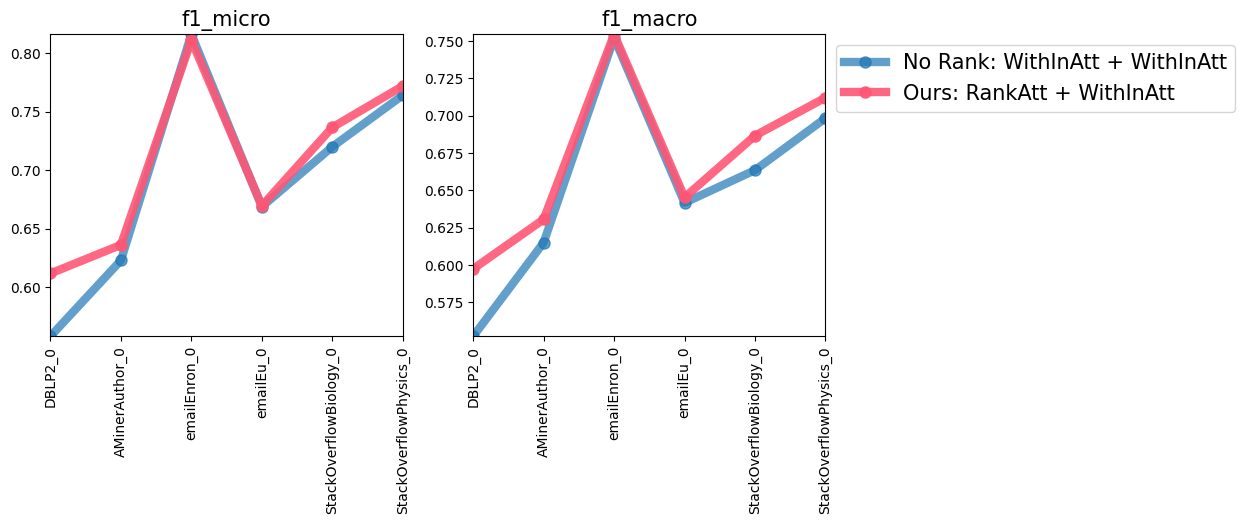

In [215]:
evallist = ["f1_micro", "f1_macro"]
w = 1/3
fig, axes = plt.subplots(dpi=100, figsize=(10,4), nrows=1, ncols=len(evallist))

for i in range(len(evallist)):
    ax = axes[i]
    evalname =  evallist[i]
    # xs
    xs = no_rank.keys()
    
    # ys
    ys =[no_rank[x][evalname] for x in xs]
    ax.plot(xs, ys, label="No Rank: WithInAtt + WithInAtt", marker="o", linewidth=6, alpha=0.7, markersize=8)
#     ax.bar(np.arange(len(xs)) + (w * (-1)), ys, width=w, align='center', label="No Rank: WithInAtt + WithInAtt")
    ys = [rank[x][evalname] for x in xs]
    ax.plot(xs, ys, label="Ours: RankAtt + WithInAtt", marker="o",  linewidth=6, alpha=0.9, markersize=8, color="#FF5675")
#     ax.bar(np.arange(len(xs)) + (w * (0)), ys, width=w, align='center', label="Ours: RankAtt + WithInAtt", color="#FF5675")
    
#     ax.set_xticks(np.arange(len(xs)))
#     ax.set_xticklabels(xs, fontsize=10)
    ax.tick_params(axis = 'x', labelrotation =90)

    if i == len(evallist) - 1:
        ax.legend(bbox_to_anchor=(1,1), fontsize=15)
    # ax.xaxis_date()
    ax.set_title(evalname, fontsize=15)
    ax.autoscale(tight=True)
    

In [122]:
no_rank = {}
rank = {}

In [123]:
no_att = {}
att1 = {}
att2 = {}
att3 = {}